In [1]:
import cv2
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [1]:
dir = 'dataset-doctor-bills1'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the MobileNet model pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (so its weights won't be updated during training)
base_model.trainable = False

# Add custom layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling instead of fully connected layers
x = Dense(1024, activation='relu')(x)  # You can adjust the number of neurons and activation function
predictions = Dense(2, activation='softmax')(x)  # Adjust to match the number of classes in your dataset

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# Assuming you have already prepared your data (train_data, validation_data)
model.fit(train_data, epochs=10, validation_data=validation_data)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory('DocumentData/train', target_size=(224, 224), batch_size=32, class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data = validation_datagen.flow_from_directory('DocumentData/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the final layer to match the number of classes (2 for forged and genuine)
model.classifier[1] = nn.Linear(model.last_channel, 2)

# Specify device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Data transformations and data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root='DocumentData/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder(root='DocumentData/validation', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}')


In [4]:
import ssl
import os
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Create ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)  # 30% of data for validation

train_data = train_datagen.flow_from_directory(
    'dataset-doctor-bills1',  # Replace with your dataset folder path
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='binary',  # Use 'binary' since it's a 2-class problem
    subset='training'  # Load training data
)

validation_data = train_datagen.flow_from_directory(
    'dataset-doctor-bills1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Load validation data
)

# Load MobileNet model pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification: 1 neuron with sigmoid

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=5,          # Stop after 5 epochs with no improvement
#     restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
# )

# Train the model for 30-50 epochs with early stopping
history = model.fit(
    train_data, 
    epochs=20,  # Maximum of 50 epochs
    validation_data=validation_data,
    # callbacks=[early_stopping]
)


Found 151 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Epoch 1/20


/Users/bhaaveshwaykole/Library/Python/3.10/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-13 08:11:50.133556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:11:52.481354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7565 - loss: 0.5779 - val_accuracy: 0.7031 - val_loss: 0.7994
Epoch 2/20


2024-10-13 08:12:15.172947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9233 - loss: 0.2605

2024-10-13 08:12:17.737402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9189 - loss: 0.2291 - val_accuracy: 0.6875 - val_loss: 0.8554
Epoch 3/20


2024-10-13 08:12:33.396045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9531 - loss: 0.1244

2024-10-13 08:12:36.552428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9581 - loss: 0.1233 - val_accuracy: 0.6562 - val_loss: 0.8027
Epoch 4/20


2024-10-13 08:12:52.168259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9601 - loss: 0.1088

2024-10-13 08:12:55.451467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9624 - loss: 0.1058 - val_accuracy: 0.7031 - val_loss: 0.9684
Epoch 5/20


2024-10-13 08:13:12.393604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9844 - loss: 0.0608

2024-10-13 08:13:14.361235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9808 - loss: 0.0752 - val_accuracy: 0.6562 - val_loss: 0.8221
Epoch 6/20


2024-10-13 08:13:30.208444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9766 - loss: 0.1052

2024-10-13 08:13:32.901743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9779 - loss: 0.0875 - val_accuracy: 0.6875 - val_loss: 1.0312
Epoch 7/20


2024-10-13 08:13:49.242167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9766 - loss: 0.0559

2024-10-13 08:13:51.726370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9795 - loss: 0.0612 - val_accuracy: 0.6875 - val_loss: 1.0077
Epoch 8/20


2024-10-13 08:14:07.316012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9766 - loss: 0.0686

2024-10-13 08:14:09.881538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9867 - loss: 0.0546 - val_accuracy: 0.6875 - val_loss: 0.8779
Epoch 9/20


2024-10-13 08:14:25.143665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0237

2024-10-13 08:14:28.058860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9978 - loss: 0.0288 - val_accuracy: 0.7031 - val_loss: 1.1413
Epoch 10/20


2024-10-13 08:14:44.249487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0266

2024-10-13 08:14:46.281609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9947 - loss: 0.0326 - val_accuracy: 0.6719 - val_loss: 0.9694
Epoch 11/20


2024-10-13 08:15:01.733635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0346

2024-10-13 08:15:04.541283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9947 - loss: 0.0331 - val_accuracy: 0.7031 - val_loss: 1.1896
Epoch 12/20


2024-10-13 08:15:20.097215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9901 - loss: 0.0307

2024-10-13 08:15:22.768362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 0.7031 - val_loss: 1.0892
Epoch 13/20


2024-10-13 08:15:38.088878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0197

2024-10-13 08:15:40.985473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.7031 - val_loss: 1.1911
Epoch 14/20


2024-10-13 08:15:56.603483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:102: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:15:59.352320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


KeyboardInterrupt: 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [16]:
# Make predictions on validation data
predictions = model.predict(validation_data)
predictions = np.round(predictions).astype(int)  # Round predictions to 0 or 1


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [17]:
true_labels = validation_data.classes


In [18]:
cm = confusion_matrix(true_labels, predictions)


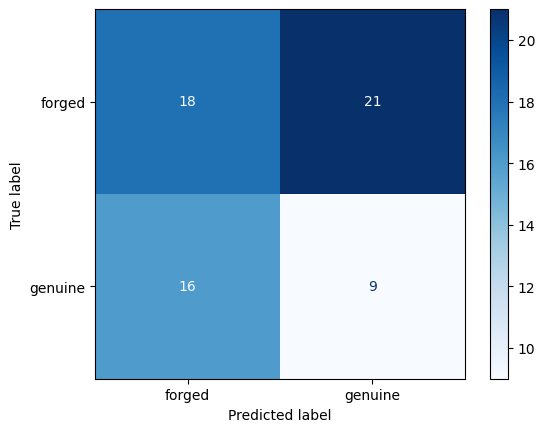

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_data.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [20]:
from sklearn.metrics import classification_report
import numpy as np

predictions = model.predict(validation_data)
predictions = np.round(predictions).astype(int)  # Convert probabilities to binary (0 or 1)

true_labels = validation_data.classes
report = classification_report(true_labels, predictions, target_names=['Genuine', 'Forged'])
print(report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
              precision    recall  f1-score   support

     Genuine       0.65      0.56      0.60        39
      Forged       0.43      0.52      0.47        25

    accuracy                           0.55        64
   macro avg       0.54      0.54      0.54        64
weighted avg       0.56      0.55      0.55        64



In [13]:
model.save("BolneLgRhi.h5")

Found 215 images belonging to 2 classes.


/Users/bhaaveshwaykole/Library/Python/3.10/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Confusion Matrix:
 [[107  23]
 [  0  85]]


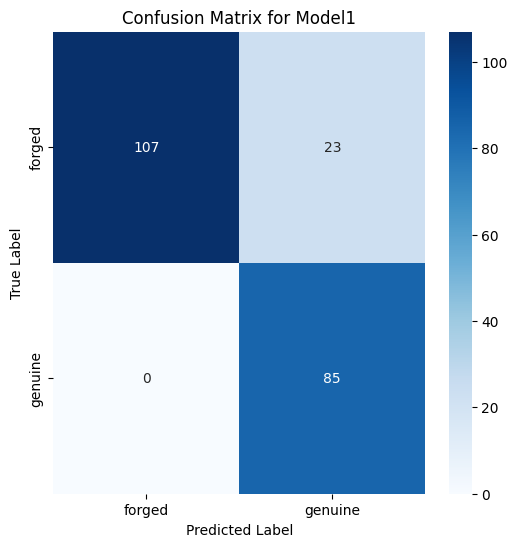

Classification Report:
               precision    recall  f1-score   support

      forged       1.00      0.82      0.90       130
     genuine       0.79      1.00      0.88        85

    accuracy                           0.89       215
   macro avg       0.89      0.91      0.89       215
weighted avg       0.92      0.89      0.89       215



In [30]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the pre-trained model1
model1 = load_model('BolneLgRhi.h5')

# Prepare the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset (replace 'dataset-doctor-bills1' with your dataset path)
test_data = test_datagen.flow_from_directory(
    'dataset-doctor-bills1',  # Your test dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Keep data order consistent
)

# Get the ground truth labels from the test data
true_labels = test_data.classes

# Predict using the loaded model
preds = model1.predict(test_data)

# Convert the predictions to binary class labels (0 or 1)
preds_labels = np.where(preds > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds_labels)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['forged', 'genuine'], yticklabels=['forged', 'genuine'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Model1')
plt.show()

# Optional: Print classification report
report = classification_report(true_labels, preds_labels, target_names=['forged', 'genuine'])
print("Classification Report:\n", report)


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data augmentation with more transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # 30% of data for validation
)

train_data = train_datagen.flow_from_directory(
    'dataset-doctor-bills1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    'dataset-doctor-bills1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load MobileNet model pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune by unfreezing some layers
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers for fine-tuning
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a reduced learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model with fine-tuning
history = model.fit(
    train_data,
    epochs=50,  # Increase epochs
    validation_data=validation_data,
    callbacks=[early_stopping, reduce_lr]
)


Found 151 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Epoch 1/50


/Users/bhaaveshwaykole/Library/Python/3.10/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-13 08:04:56.479572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:04:59.590234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7699 - loss: 0.4651 - val_accuracy: 0.5312 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 2/50


2024-10-13 08:05:42.544275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:05:44.704327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9336 - loss: 0.2505 - val_accuracy: 0.4531 - val_loss: 3.6547 - learning_rate: 0.0010
Epoch 3/50


2024-10-13 08:06:04.234414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:06:06.681495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9060 - loss: 0.2299 - val_accuracy: 0.5156 - val_loss: 3.6144 - learning_rate: 0.0010
Epoch 4/50


2024-10-13 08:06:25.389692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:06:28.082832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9422 - loss: 0.1575 - val_accuracy: 0.3906 - val_loss: 10.6199 - learning_rate: 0.0010
Epoch 5/50


2024-10-13 08:06:47.171700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:06:49.334619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9559 - loss: 0.1076 - val_accuracy: 0.3906 - val_loss: 10.1185 - learning_rate: 2.0000e-04
Epoch 6/50


2024-10-13 08:07:08.266791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:76: Filling up shuffle buffer (this may take a while): 4 of 8
2024-10-13 08:07:10.352090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9646 - loss: 0.0656 - val_accuracy: 0.4062 - val_loss: 8.8936 - learning_rate: 2.0000e-04


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [23]:
# Make predictions on validation data
predictions = model.predict(validation_data)
predictions = np.round(predictions).astype(int)  # Round predictions to 0 or 1


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [24]:
true_labels = validation_data.classes


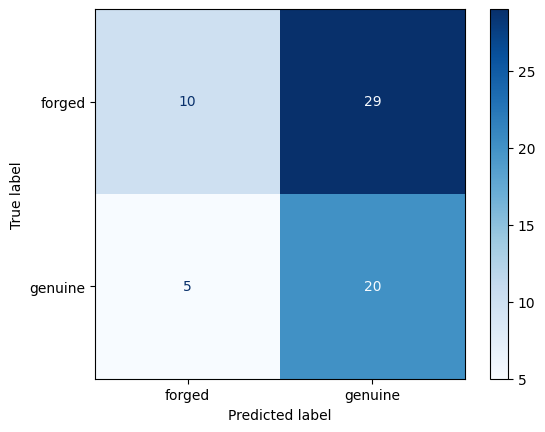

In [25]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_data.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [26]:
model.save("BolneLgRhiAdvance.h5")

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load both models from .h5 files
model1 = load_model('model1.h5')
model2 = load_model('model2.h5')

# Load the validation or test data for predictions
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    'dataset-doctor-bills1',  # Replace with your test dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important to avoid shuffling to match order of predictions
)

# Predict with both models
preds1 = model1.predict(test_data)
preds2 = model2.predict(test_data)

# Average the predictions from both models
ensemble_preds = (preds1 + preds2) / 2.0

# Convert to binary class labels (e.g., forged/genuine)
ensemble_preds_class = np.where(ensemble_preds > 0.5, 1, 0)

# Evaluate ensemble model by comparing with true labels
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels from the generator
true_labels = test_data.classes

# Print confusion matrix
cm = confusion_matrix(true_labels, ensemble_preds_class)
print("Confusion Matrix:\n", cm)

# Print classification report
report = classification_report(true_labels, ensemble_preds_class, target_names=['forged', 'genuine'])
print("Classification Report:\n", report)


In [31]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load both models from .h5 files
model1 = load_model('BolneLgRhi.h5')
model2 = load_model('BolneLgRhiAdvance.h5')

# Load the validation or test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    'dataset-doctor-bills1',  # Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Avoid shuffling to maintain order
)

# Predict with both models
preds1 = model1.predict(test_data)
preds2 = model2.predict(test_data)

# Get the true labels from the test data
true_labels = test_data.classes

# Prepare the stacking input features (combine predictions)
stacked_features = np.column_stack((preds1, preds2))

# Split data into training and validation for XGBoost
X_train, X_val, y_train, y_val = train_test_split(stacked_features, true_labels, test_size=0.3, random_state=42)

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Predict with the XGBoost meta-model
xgb_preds = xgb_clf.predict(X_val)

# Evaluate the meta-model
cm = confusion_matrix(y_val, xgb_preds)
print("Confusion Matrix:\n", cm)

report = classification_report(y_val, xgb_preds, target_names=['forged', 'genuine'])
print("Classification Report:\n", report)


Found 215 images belonging to 2 classes.


/Users/bhaaveshwaykole/Library/Python/3.10/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
Confusion Matrix:
 [[36  3]
 [ 3 23]]
Classification Report:
               precision    recall  f1-score   support

      forged       0.92      0.92      0.92        39
     genuine       0.88      0.88      0.88        26

    accuracy                           0.91        65
   macro avg       0.90      0.90      0.90        65
weighted avg       0.91      0.91      0.91        65



In [33]:
import pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)

print("XGBoost model saved as xgb_model.pkl")

XGBoost model saved as xgb_model.pkl
